# produce_cmip6_summary_figs.ipynb
Plot summary figures using data produced by process_cmip6_file.ipynb.

B. S. Grandey, 2022

In [1]:
! date

Sat Jan 29 22:31:37 +08 2022


In [2]:
from cdo import Cdo, CDOException
import matplotlib.pyplot as plt
import pathlib
import xarray as xr

%matplotlib inline

In [3]:
cdo = Cdo(tempdir='temp')

print(f'CDO version: {cdo.version()}')
print(f'cdo.py bindings version: {cdo.__version__()}')

print(f'xarray version: {xr.__version__}')

CDO version: 2.0.3
cdo.py bindings version: 1.5.4
xarray version: 0.21.0


In [4]:
# Reduce resolution of inline images (to reduce size of this notebook)
plt.rcParams['figure.dpi'] = 48.0

In [5]:
# Input base directory containing files produced by process_cmip6_file.ipynb
in_base = pathlib.Path('~/Data/p22c/CMIP6/').expanduser()
# Output base directory in which to save figures
out_base = pathlib.Path('~/Data/p22c/CMIP6_figs/').expanduser()
out_base.mkdir(exist_ok=True)

## Function to produce timeseries of fldmeans for all source-member pairs (rows) and experiments (columns) of interest for a given variable
These timeseries figures provide a quick summary of available data coverage, especially when all_source_member_pairs=True.

In [6]:
def fig_timeseries(variable='zostoga',
                   in_group='regrid_yearmean',  # directory within in_base
                   experiments=['piControl', 'historical', 'ssp585', 'ssp370', 'ssp245', 'ssp126'],
                   all_source_member_pairs=True,  # include source-member paris that have data for any variable?
                  ):
    print(f'---- {in_group} {variable} ----')
    # Output directory
    out_dir = out_base.joinpath(in_group)
    out_dir.mkdir(exist_ok=True)
    # Identify available source-member pairs
    if all_source_member_pairs:  # include source-member pairs that have data for any variable?
        source_member_pairs = [d.name for d in in_base.glob(f'{in_group}/*/[!.]*_*')]
        source_member_pairs = sorted(set(source_member_pairs))  # remove duplicates
    else:  # or only include source-member pairs that have data for this specific variable?
        source_member_pairs = sorted([d.name for d in in_base.glob(f'{in_group}/{variable}/[!.]*_*')])
    # Configure subplots
    nrows = len(source_member_pairs)
    ncols = len(experiments)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows,
                            figsize=(ncols*3, nrows*3), constrained_layout=True)
    fig.suptitle(variable, fontsize='xx-large')  # main title
    # Loop over rows and cols
    for r in range(nrows):
        source_member = source_member_pairs[r]
        axs[r,0].set_ylabel(f'{source_member}\n{variable}')  # label row
        for c in range(ncols):
            exp = experiments[c]
            ax = axs[r,c]  # select axis
            if r == 0:
                ax.set_title(exp)  # label column
            # Input data directory
            in_dirs = sorted(in_base.glob(f'{in_group}/{variable}/{source_member}/*.{exp}.*'))
            if len(in_dirs) == 0:
                continue  # skip to next column
            elif len(in_dirs) > 1:
                print(f'Warning: {len(in_dirs)} possible input directories found for {source_member} {exp}')
            in_dir = in_dirs[-1]
            # Input files
            in_fns = sorted([str(f) for f in in_dir.glob(f'*.nc')])
            # Use CDO to merge files (if necessary), calculate fldmean, and use an absolute time axis
            temp_fn = cdo.fldmean(input=f'-mergetime {" ".join(in_fns)}',
                                  options='-a -f nc', env={"SKIP_SAME_TIME": "1"})
            # Read data using xarray
            ds = xr.open_dataset(temp_fn)
            # Lineplot
            ax.plot(ds['time']/1e4, ds[variable][:,0,0])
    # Save
    out_fn = out_dir.joinpath(f'timeseries_{variable}_{nrows}x{ncols}.pdf')
    fig.savefig(out_fn)
    print(f'Written {in_group}/{out_fn.name}')
    return fig

---- regrid_yearmean zostoga ----
Written regrid_yearmean/timeseries_zostoga_51x6.pdf
CPU times: user 16.3 s, sys: 5.79 s, total: 22.1 s
Wall time: 1min 14s


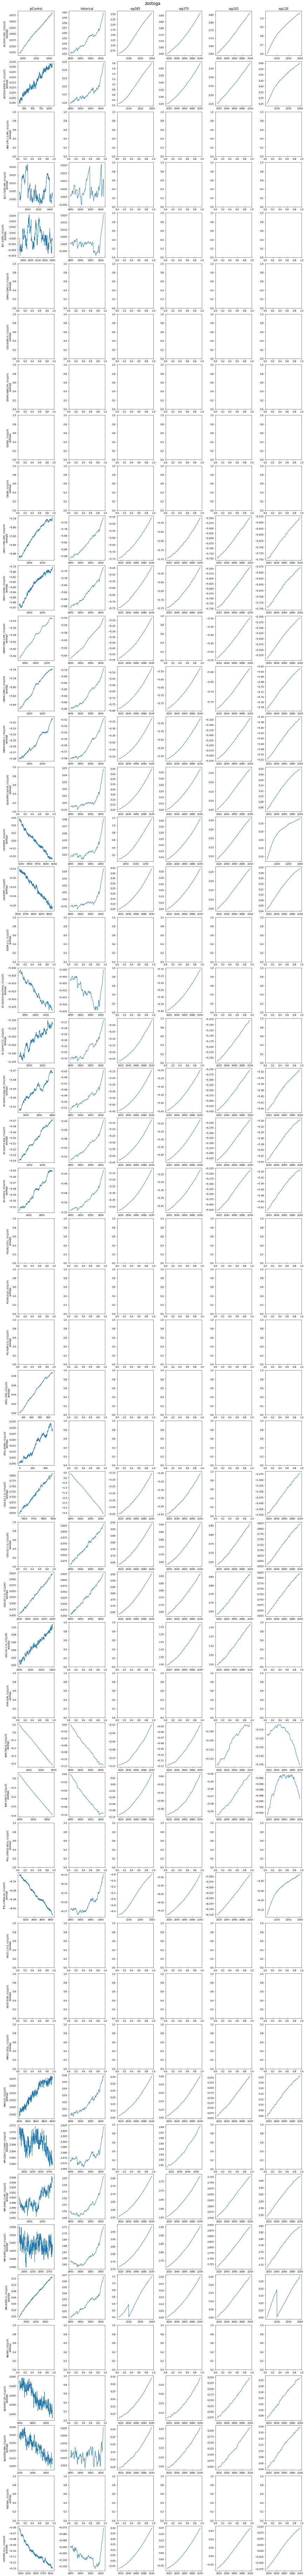

In [7]:
%%time
# Loop over variables of interest and plot timerseries
for variable in ['zostoga', ]:
    fig = fig_timeseries(variable=variable)

In [8]:
! date

Sat Jan 29 22:33:24 +08 2022
